In [1]:
import torchvision.models as models
import torch
from alexnet_pytorch import AlexNet as alexnet2
from util.layervisualization import CNNLayerVisualization
from util.modelregressions import CNNCrossFit
from util.misc_functions import float2rgb
from dataset.hvm import HVMDataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# load up target and source models
squeezenet_target = models.squeezenet1_0(pretrained=True).features
squeezenet_source = models.squeezenet1_1(pretrained=True).features
alexnet_source = models.alexnet(pretrained=True).features

# pre-load data into memory for speed
hvmdataset = HVMDataset(5500)

In [3]:
# define basic params 
cnn_layer = 7
source_units = np.arange(128)
target_units = np.arange(128)
img_dim = [256,256,3]

In [ ]:
# create a control experiment (squeezenet1_1-->squeezenet1_0)
snet2snet4000 = CNNCrossFit(squeezenet_target,squeezenet_source,cnn_layer,target_units,source_units)
# extract layer activation across two models
snet2snet4000.design(hvmdataset,4000,1500)
# linear prediction of target unit, record performance
snet2snet4000.fit()
# implement source control of target units, record performance
snet2snet4000.control()

In [37]:
snet2snet4000.target_net[:5]

Sequential(
  (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
)

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
plt.plot(snet2snet4000.train_score,snet2snet.test_score,'.')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim((0,1))
plt.xlabel('train score')
plt.ylabel('test score')
plt.subplot(1,3,2)
plt.plot(snet2snet4000.target_act,snet2snet.source_act,'.')
plt.axis('tight')
plt.xlabel('optimized act. target model')
plt.ylabel('optimized act. source model')
plt.subplot(1,3,3)
plt.plot(snet2snet4000.test_score,snet2snet.ctr_score,'.')
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('test score')
plt.ylabel('fraction act. source/target')
plt.show()

In [ ]:
# pre-load data into memory for speed
hvmdataset = HVMDataset(2500)
# create a control experiment (squeezenet1_1-->squeezenet1_0)
snet2snet2000 = CNNCrossFit(squeezenet_target,squeezenet_source,cnn_layer,target_units,source_units)
# extract layer activation across two models
snet2snet2000.design(hvmdataset,1000,1500)
# linear prediction of target unit, record performance
snet2snet2000.fit()
# implement source control of target units, record performance
snet2snet2000.control()

In [ ]:
# create a control experiment (squeezenet1_1-->squeezenet1_0)
snet2snet1000 = CNNCrossFit(squeezenet_target,squeezenet_source,cnn_layer,target_units,source_units)
# extract layer activation across two models
snet2snet1000.design(hvmdataset,1000,1000)
# linear prediction of target unit, record performance
snet2snet1000.fit()
# implement source control of target units, record performance
snet2snet1000.control()

plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
plt.plot(snet2snet1000.train_score,snet2snet.test_score,'.')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim((0,1))
plt.xlabel('train score')
plt.ylabel('test score')
plt.subplot(1,3,2)
plt.plot(snet2snet1000.target_act,snet2snet.source_act,'.')
plt.axis('tight')
plt.xlabel('optimized act. target model')
plt.ylabel('optimized act. source model')
plt.subplot(1,3,3)
plt.plot(snet2snet1000.test_score,snet2snet.ctr_score,'.')
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('test score')
plt.ylabel('fraction act. source/target')
plt.show()

In [4]:
# pre-load data into memory for speed
hvmdataset = HVMDataset(1200)
# create a control experiment (squeezenet1_1-->squeezenet1_0)
snet2snet200 = CNNCrossFit(squeezenet_target,squeezenet_source,cnn_layer,target_units,source_units)
# extract layer activation across two models
snet2snet200.design(hvmdataset,200,1000)
# linear prediction of target unit, record performance
snet2snet200.fit()
# implement source control of target units, record performance
snet2snet200.control()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [30:40<00:00, 14.09s/it]


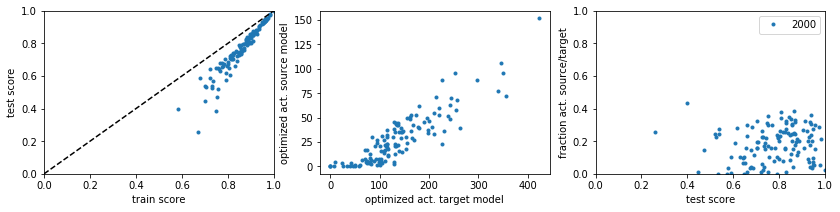

In [5]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
#plt.plot(snet2snet100.train_score,snet2snet100.test_score,'.')
#plt.plot(snet2snet2000.train_score,snet2snet.test_score,'.')
plt.plot(snet2snet200.train_score,snet2snet200.test_score,'.')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim((0,1))
plt.xlabel('train score')
plt.ylabel('test score')
plt.subplot(1,3,2)
#plt.plot(snet2snet100.target_act,snet2snet100.source_act,'.')
#plt.plot(snet2snet2000.target_act,snet2snet.source_act,'.')
plt.plot(snet2snet200.target_act,snet2snet200.source_act,'.')
plt.axis('tight')
plt.xlabel('optimized act. target model')
plt.ylabel('optimized act. source model')
plt.subplot(1,3,3)
#plt.plot(snet2snet100.test_score,snet2snet100.ctr_score,'.',label='4000')
plt.plot(snet2snet200.test_score,snet2snet200.ctr_score,'.',label='2000')
plt.legend()
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('test score')
plt.ylabel('fraction act. source/target')
plt.show()

In [ ]:
# create two feature visualization objects
img_dim = [256,256,3]
niter = 100
layer_vis_target = CNNLayerVisualization(squeezenet_target, cnn_layer, target_units,img_dim)

# Image sythesis with pytorch hooks
[Img_target, target_val] = layer_vis_target.visualise_layer_with_hooks(niter=niter)
#[Img_source, source_val] = layer_vis_source.visualise_layer_with_hooks(niter=niter, w = snet2snet.w, b = snet2snet.b)

In [ ]:
img = np.zeros((img_dim[0]*img_dim[1]*img_dim[2],niter))
plt.figure(figsize=(15,40))
for i in range(niter):
    im_path = 'generated/layer_vis_l' + str(cnn_layer) + \
        '_f' + str(source_units) + '_iter' + str(i+1) + '.jpg'
    tempimg=mpimg.imread(im_path)
    img[:,i] = tempimg.flatten()
    if i%(niter/5) == 0:
        plt.subplot(1,5,round(i/(niter/5))+1)
        plt.imshow(tempimg)
        plt.axis('off')
        plt.clim([0,1])
plt.show()

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA

D = img[:,0:-2:1]-img[:,1:-1:1];
[d,n] = D.shape
pca = PCA(n_components=n,whiten=False)
pca.fit(D)


In [ ]:
Dpca = pca.transform(D)
Dproj_pc1 = Dpca[:,0].reshape(img_dim)

plt.figure(figsize=(15,40))
plt.subplot(1,4,1)
plt.imshow(float2rgb(tempimg))
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(float2rgb(Dproj_pc1))
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(float2rgb(D[:,5].reshape(img_dim)))
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(float2rgb(D[:,-5].reshape(img_dim)))
plt.axis('off')
plt.show()

In [ ]:
plt.plot(pca.explained_variance_,'.')
plt.show()
plt.plot(target_val)
plt.plot(source_val)
plt.show()

In [ ]:
for index, layer in enumerate(squeezenet_target):
    if index == cnn_layer:
        print(layer.squeeze.weight.shape)
        print(layer.squeeze.weight[filter_pos,filter_pos,:,:].detach().numpy().squeeze())
for index, layer in enumerate(squeezenet_target):
    if index == cnn_layer:
        print(layer.squeeze.weight.shape)
        print(layer.squeeze.weight[filter_pos,filter_pos,:,:].detach().numpy().squeeze())

In [ ]:
squeezenetf1

In [ ]:
squeezenetf2

In [ ]:
img_dir = r'C:\Users\Chong Guo\.brainio\image_dicarlo_hvm'
img_list= [file for file in os.listdir(img_dir) if file.endswith('.png')]
HVM = [None] * len(img_list)
for [index,imgname] in enumerate(img_list[:10]):        
            HVM[index]=mpimg.imread(img_dir+os.path.sep+imgname)

In [ ]:
plt.imshow(hvmdataset[0])
plt.show()

In [ ]:
len([])